In [2]:
import matplotlib.pyplot as plt
import torch

import plenoptic as po

# so that relative sizes of axes created by po.imshow and others look right
plt.rcParams["figure.dpi"] = 72

%matplotlib inline

plt.rcParams["animation.html"] = "html5"
# use single-threaded ffmpeg for animation writer
plt.rcParams["animation.writer"] = "ffmpeg"
plt.rcParams["animation.ffmpeg_args"] = ["-threads", "1"]

# this notebook runs just about as fast with GPU and CPU
DEVICE = torch.device("cpu")


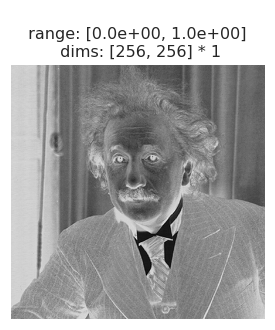

In [3]:
im = po.data.einstein().to(DEVICE)
fig = po.imshow(1-im)

In [4]:
# this is a convenience function for creating a simple Gaussian kernel
from plenoptic.simulate.canonical_computations.filters import (
    circular_gaussian2d,
)


# Simple rectified Gaussian convolutional model
class SimpleModel(torch.nn.Module):
    # in __init__, we create the object, initializing the convolutional weights and
    # nonlinearity
    def __init__(self, kernel_size=(7, 7)):
        super().__init__()
        self.kernel_size = kernel_size
        self.conv = torch.nn.Conv2d(
            1, 1, kernel_size=kernel_size, padding=(0, 0), bias=False
        )
        self.conv.weight.data[0, 0] = circular_gaussian2d(kernel_size, 3.0)

    # the forward pass of the model defines how to get from an image to the model's
    # representation
    def forward(self, x):
        # use circular padding so our output is the same size as our input
        x = po.tools.conv.same_padding(x, self.kernel_size, pad_mode="circular")
        return self.conv(x)


model = SimpleModel()
model.eval()
model.to(DEVICE)
rep = model(im)

print(im.shape)
print(rep.shape)

torch.Size([1, 1, 256, 256])
torch.Size([1, 1, 256, 256])


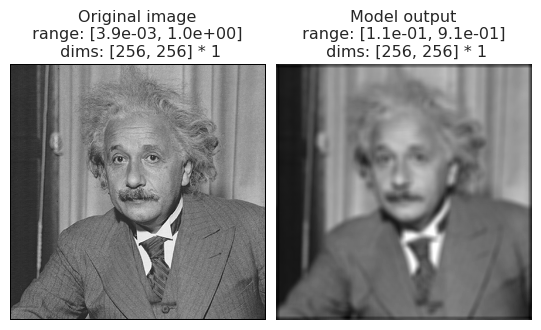

In [5]:
fig = po.imshow(torch.cat([im, rep]), title=["Original image", "Model output"])

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

/home/alban/DeepVis/lib/python3.10/site-packages/plenoptic/synthesize/metamer.py:285: UserWarning: Loss has converged, stopping synthesis
  warnings.warn("Loss has converged, stopping synthesis")


<Axes: xlabel='Synthesis iteration', ylabel='Loss'>

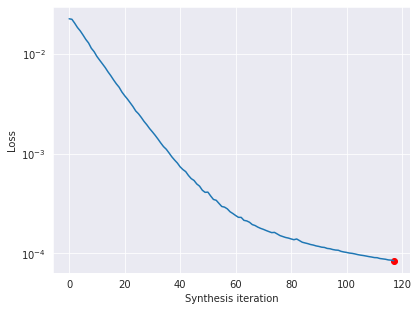

In [6]:
po.tools.remove_grad(model)

metamer = po.synth.Metamer(im, model)

matched_im = metamer.synthesize(store_progress=True, max_iter=20)
# if we call synthesize again, we resume where we left off
matched_im = metamer.synthesize(store_progress=True, max_iter=150)

po.synth.metamer.plot_loss(metamer)

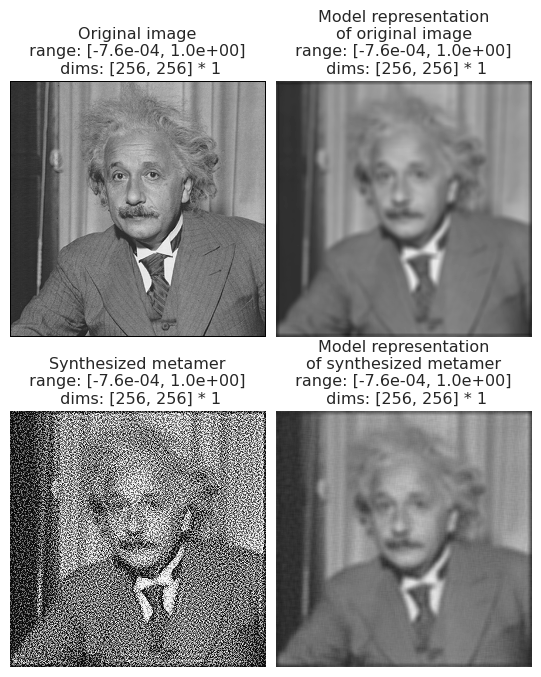

In [7]:
fig = po.imshow(
    [im, rep, metamer.metamer, model(metamer.metamer)],
    col_wrap=2,
    vrange="auto1",
    title=[
        "Original image",
        "Model representation\nof original image",
        "Synthesized metamer",
        "Model representation\nof synthesized metamer",
    ],
)

  0%|          | 0/500 [00:00<?, ?it/s]

<Axes: xlabel='Synthesis iteration', ylabel='Loss'>

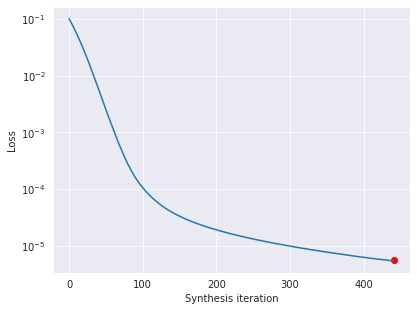

In [11]:
curie = po.data.curie().to(DEVICE)

metamer = po.synthesize.Metamer(
    im,
    model,
)
metamer.setup(initial_image=curie)

# we increase the length of time we run synthesis and decrease the
# stop_criterion, which determines when we think loss has converged
# for stopping synthesis early.
synth_image = metamer.synthesize(store_progress=True, max_iter=500, stop_criterion=1e-6)
po.synth.metamer.plot_loss(metamer)

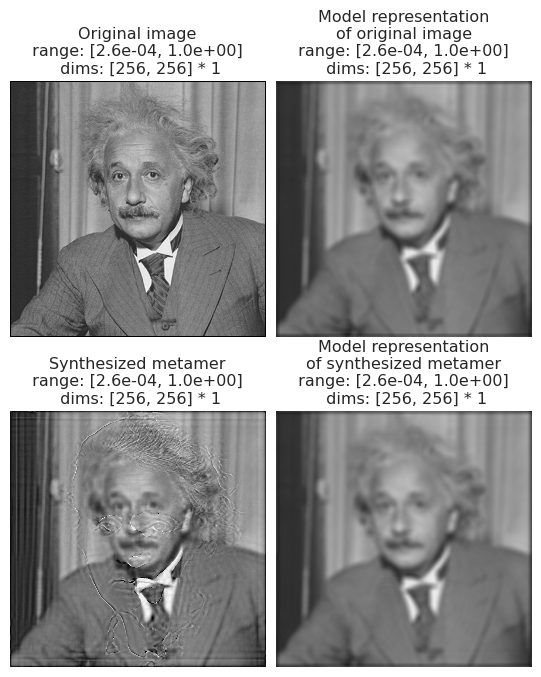

In [12]:
fig = po.imshow(
    [im, rep, metamer.metamer, model(metamer.metamer)],
    col_wrap=2,
    vrange="auto1",
    title=[
        "Original image",
        "Model representation\nof original image",
        "Synthesized metamer",
        "Model representation\nof synthesized metamer",
    ],
)